In [206]:
'''
Imports
'''
import h5py
# import os
# import shutil
import csv
import pandas as pd
import numpy as np
from io import BytesIO
from PIL import Image
import cv2
import torch, torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [12]:
'''
Constants
'''
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
LEARNING_RATE = 0.01
CLASSES = 1
EPOCH = 5
NEG_POS_RATIO = 25

In [3]:
# Paths
## Kaggle
# TRAIN_HDF5_PATH = "/kaggle/input/isic-2024-challenge/train-image.hdf5"
# TEST_HDF5_PATH = "/kaggle/input/isic-2024-challenge/test-image.hdf5"
# ANNOTATIONS_FILE = "/kaggle/input/isic-2024-challenge/train-metadata.csv"
# MODEL_SAVE_PATH = "/kaggle/working/model_resnet34_aug_2-2.pth"
# LOG_FILE = "/kaggle/working/log_res34_aug.csv"
# RESNET34_IMAGENET_WEIGHTS_PYTORCH = "/kaggle/input/resnet34-weights/pytorch/nan/1/resnet34-b627a593.pth"        # change properly
# SUBMISSION_FILE_PATH = "/kaggle/working/submission.csv"

## Local_Srijan
TRAIN_HDF5_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\train-image.hdf5"
TEST_HDF5_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\test-image.hdf5"
ANNOTATIONS_FILE = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\train-metadata.csv"
MODEL_SAVE_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\model_resnet34_aug_2-2.pth"
LOG_FILE = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Codebase\\Classification_v2\\log_res34_aug.csv"
RESNET34_IMAGENET_WEIGHTS_PYTORCH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\resnet34-b627a593.pth"        # change properly
SUBMISSION_FILE_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Codebase\\Classification_v2\\submission.csv"

## Local_Sruba
# TRAIN_HDF5_PATH = "/kaggle/input/isic-2024-challenge/train-image.hdf5"
# TEST_HDF5_PATH = "/kaggle/input/isic-2024-challenge/test-image.hdf5"
# ANNOTATIONS_FILE = "/kaggle/input/isic-2024-challenge/train-metadata.csv"
# MODEL_SAVE_PATH = "/kaggle/working/model_resnet34_aug_2-2.pth"
# LOG_FILE = "/kaggle/working/log_res34_aug.csv"
# RESNET34_IMAGENET_WEIGHTS_PYTORCH = "/kaggle/input/resnet34-weights/pytorch/nan/1/resnet34-b627a593.pth"        # change properly
# SUBMISSION_FILE_PATH = "/kaggle/working/submission.csv"

In [84]:
annotations_df_full = pd.read_csv(ANNOTATIONS_FILE, low_memory=False)
df_positive_all = annotations_df_full[annotations_df_full["target"] == 1].reset_index(drop=True)
df_negative_all = annotations_df_full[annotations_df_full["target"] == 0].reset_index(drop=True)

In [85]:
print(df_positive_all.shape, df_negative_all.shape)

(393, 55) (400666, 55)


In [86]:
df_negative_trunc = df_negative_all.sample(df_positive_all.shape[0]*NEG_POS_RATIO)
df_negative_trunc.shape

(9825, 55)

In [87]:
annotations_df_trunc = pd.concat([df_positive_all, df_negative_trunc]).sample(frac=1).reset_index()
annotations_df_trunc.shape

(10218, 56)

In [88]:
annotations_df_trunc.sample(5)

,index,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
3529,302547,ISIC_7574103,0,IP_7541961,60.0,male,upper extremity,4.73,TBP tile: close-up,3D: XP,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,91.111120
1573,305654,ISIC_7651883,0,IP_1400932,55.0,male,lower extremity,4.21,TBP tile: close-up,3D: white,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.440295
5680,194311,ISIC_4897572,0,IP_7148655,40.0,male,head/neck,3.30,TBP tile: close-up,3D: XP,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,51.749420
5471,112719,ISIC_2869513,0,IP_6774617,70.0,male,lower extremity,6.27,TBP tile: close-up,3D: XP,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,84.822240
7122,98113,ISIC_2505952,0,IP_5714646,40.0,male,lower extremity,5.34,TBP tile: close-up,3D: XP,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,56.076230


In [89]:
annotations_df_trunc['isic_id'][0]

'ISIC_2673356'

In [90]:
list(annotations_df_trunc.set_index('isic_id')['target'].to_dict().keys())

['ISIC_2673356',
 'ISIC_7961631',
 'ISIC_0339635',
 'ISIC_8922985',
 'ISIC_9389945',
 'ISIC_0479435',
 'ISIC_8204262',
 'ISIC_7295766',
 'ISIC_5968002',
 'ISIC_4344863',
 'ISIC_0422344',
 'ISIC_5971778',
 'ISIC_9186268',
 'ISIC_3286531',
 'ISIC_4390219',
 'ISIC_5233957',
 'ISIC_7463117',
 'ISIC_8604224',
 'ISIC_6532931',
 'ISIC_1053288',
 'ISIC_0991123',
 'ISIC_5216060',
 'ISIC_4297415',
 'ISIC_8277848',
 'ISIC_7292466',
 'ISIC_3898488',
 'ISIC_8734473',
 'ISIC_9320575',
 'ISIC_3020567',
 'ISIC_7641316',
 'ISIC_6901070',
 'ISIC_7776526',
 'ISIC_8160997',
 'ISIC_0289681',
 'ISIC_8717913',
 'ISIC_9096918',
 'ISIC_4441294',
 'ISIC_0656316',
 'ISIC_9244907',
 'ISIC_1090922',
 'ISIC_8628953',
 'ISIC_9296953',
 'ISIC_4851249',
 'ISIC_4296990',
 'ISIC_9459782',
 'ISIC_1744424',
 'ISIC_2551659',
 'ISIC_7674837',
 'ISIC_9258297',
 'ISIC_7379567',
 'ISIC_0586883',
 'ISIC_1797934',
 'ISIC_5035525',
 'ISIC_2906351',
 'ISIC_0961093',
 'ISIC_1471091',
 'ISIC_9248863',
 'ISIC_0206782',
 'ISIC_9027229

In [167]:
'''
DataClass
'''
class ISIC2024_HDF5(Dataset):
    def __init__(self, hdf5_path, annotations_df=None, transform=None):
        self.hdf5_path = hdf5_path
        self.annotations_df = annotations_df
        self.transform = transform
        self.image_ids = []
        
        self.hdf5_file = h5py.File(self.hdf5_path, 'r')

        if self.annotations_df is not None:
            self.image_ids = annotations_df['isic_id']
            self.labels = annotations_df.set_index('isic_id')['target'].to_dict()
        else:
            self.image_ids = list(self.hdf5_file.keys())
            

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(BytesIO(self.hdf5_file[image_id][()]))
        # image = self.load_image(self.hdf5_file[image_id][()])

        if self.transform:
            image = self.transform(image)

        # Check for NaN in image
        if torch.isnan(image).any():
            print(f"NaN detected in image {image_id}")

        if self.annotations_df is not None:
            label = self.labels[image_id]
            # Check for NaN in label
            if np.isnan(label):
                print(f"NaN detected in label for image {image_id}")
            return image, label, image_id
        else:
            return image, image_id
        
    # def load_image(self, image_data):
    #     # Decode the image data from HDF5 file using OpenCV
    #     image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    #     # image = np.transpose(image, (1, 2, 0))  # Convert HxWxC to CxHxW
    #     return image
    
    def close(self):
        self.hdf5_file.close()

In [104]:
'''
Transformations
'''
TRAIN_TRANS = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.RandomRotation(degrees=(0, 360)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale = True)
])
TEST_TRANS = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True)
])

In [168]:
train_dataset = ISIC2024_HDF5(TRAIN_HDF5_PATH, annotations_df_trunc, transform=TRAIN_TRANS)
len(train_dataset)

10218

In [151]:
test_dataset = ISIC2024_HDF5(TEST_HDF5_PATH, transform=TEST_TRANS)
len(test_dataset)

3

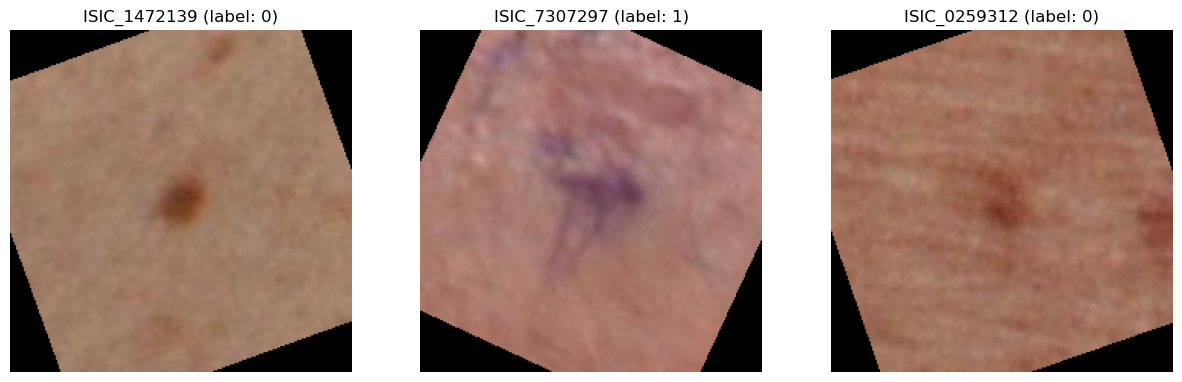

In [205]:
def visualize_train_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC and convert to numpy
        plt.imshow(image)
        if titles:
            plt.title(f"{titles[0][i]} (label: {titles[1][i]})")
        plt.axis('off')
    plt.show()
indices = np.random.choice(len(train_dataset), size=3, replace=False)
images, label, image_ids  = zip(*[train_dataset[i] for i in indices])
visualize_train_images(images, titles=[image_ids, label])

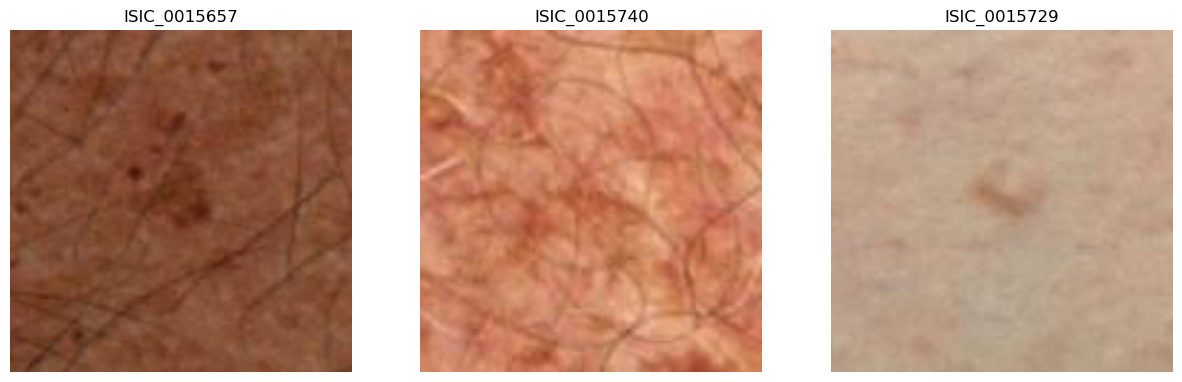

In [186]:
def visualize_test_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC and convert to numpy
        plt.imshow(image)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()
indices = np.random.choice(len(test_dataset), size=3, replace=False)
images, image_ids  = zip(*[test_dataset[i] for i in indices])
visualize_test_images(images, titles=image_ids)

In [261]:
data_transforms = {
    "train": A.Compose([
        A.Resize(224, 224),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        # A.HueSaturationValue(
        #         hue_shift_limit=0.2, 
        #         sat_shift_limit=0.2, 
        #         val_shift_limit=0.2, 
        #         p=0.5
        #     ),
        # A.RandomBrightnessContrast(
        #         brightness_limit=(-0.1,0.1), 
        #         contrast_limit=(-0.1, 0.1), 
        #         p=0.5
        #     ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "test": A.Compose([
        A.Resize(224, 224),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}
class ISIC2024_HDF5_ALBUM(Dataset):
    def __init__(self, hdf5_path, annotations_df=None, transform=None):
        self.hdf5_path = hdf5_path
        self.annotations_df = annotations_df
        self.transform = transform
        self.image_ids = []
        
        self.hdf5_file = h5py.File(self.hdf5_path, 'r')

        if self.annotations_df is not None:
            self.image_ids = annotations_df['isic_id']
            self.labels = annotations_df.set_index('isic_id')['target'].to_dict()
        else:
            self.image_ids = list(self.hdf5_file.keys())
            

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = np.array(Image.open(BytesIO(self.hdf5_file[image_id][()])))
        
        # image = self.load_image(self.hdf5_file[image_id][()])

        if self.transform:
            # image = self.transform(image)
            image = self.transform(image=image)["image"]        # Albumentations returns a dictionary with keys like 'image', 'mask', etc., depending on the transformations applied.

        # Check for NaN in image
        if torch.isnan(image).any():
            print(f"NaN detected in image {image_id}")

        if self.annotations_df is not None:
            label = self.labels[image_id]
            # Check for NaN in label
            if np.isnan(label):
                print(f"NaN detected in label for image {image_id}")
            return image, label, image_id
        else:
            return image, image_id
        
    # def load_image(self, image_data):
    #     # Decode the image data from HDF5 file using OpenCV
    #     image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    #     # image = np.transpose(image, (1, 2, 0))  # Convert HxWxC to CxHxW
    #     return image
    
    def close(self):
        self.hdf5_file.close()
train_dataset_album = ISIC2024_HDF5_ALBUM(TRAIN_HDF5_PATH, annotations_df_trunc, transform=data_transforms["train"])
test_dataset_album = ISIC2024_HDF5_ALBUM(TEST_HDF5_PATH, transform=data_transforms["test"])
print(len(train_dataset_album), len(test_dataset_album))

10218 3


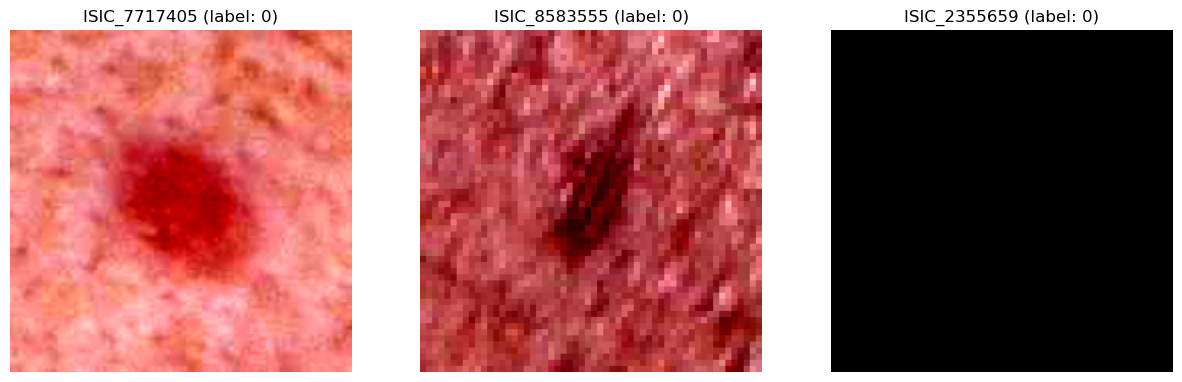

In [262]:
def visualize_train_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC and convert to numpy
        plt.imshow(image)
        if titles:
            plt.title(f"{titles[0][i]} (label: {titles[1][i]})")
        plt.axis('off')
    plt.show()
indices = np.random.choice(len(train_dataset_album), size=3, replace=False)
images, label, image_ids  = zip(*[train_dataset_album[i] for i in indices])
visualize_train_images(images, titles=[image_ids, label])

In [240]:
img, _, _ = train_dataset_album[0]

In [243]:
img.

tensor(-1.6127)